<a href="https://colab.research.google.com/github/austin-leung/whos-that-pokemon/blob/master/pokemonCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Who's That Pokémon?

A convolutional neural network trained to identify Pokémon. Currently a work in progress!

![alt text](https://i.ytimg.com/vi/09saU1wbuBo/maxresdefault.jpg)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
from google.colab import files
files.upload()

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

In [0]:
!kaggle datasets download -d mrgravelord/complete-pokemon-image-dataset -p /content/drive/My\ Drive/pkmnDataset

In [0]:
import os
!unzip -q /content/drive/My\ Drive/pkmnDataset/complete-pokemon-image-dataset.zip -d /content/drive/My\ Drive/pkmnImgs

In [0]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as testing
test_size = 0.2

# convert data to a normalized torch.FloatTensor
trainTransform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Download and load the data
imgData = datasets.ImageFolder('/content/drive/My Drive/pkmnImgsSubset', transform=trainTransform)

# obtain training indices that will be used for training and testing datasets
num_train = len(imgData)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

# define samplers for obtaining training and test batches
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

# We take 64 images per batch
trainloader = torch.utils.data.DataLoader(imgData, batch_size=64, 
                                          sampler=train_sampler)
testloader = torch.utils.data.DataLoader(imgData, batch_size=64, 
                                           sampler=test_sampler)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

(64, 3, 32, 32)
{0: 'Abomasnow', 1: 'Abra', 2: 'Absol', 3: 'Accelgor', 4: 'Aegislash', 5: 'Aerodactyl', 6: 'Aggron', 7: 'Aipom', 8: 'Alakazam', 9: 'Alomomola'}


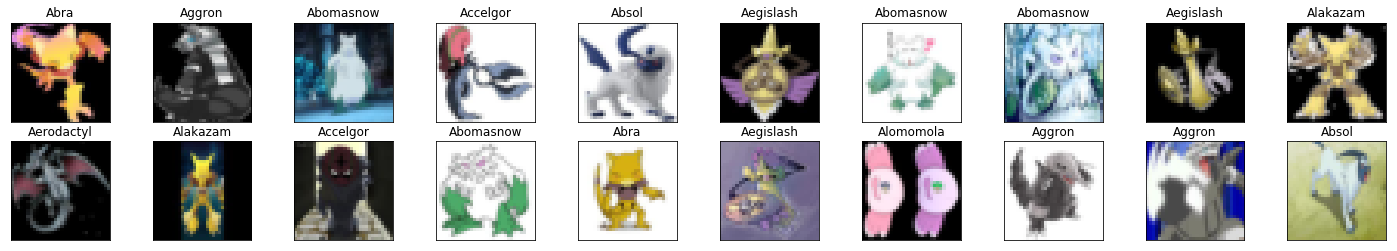

In [0]:
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print(images.shape)

# create a dictionary mapping labels to pokemon
pkmnIndDict = imgData.class_to_idx
classes = list(pkmnIndDict.keys())
pkmnIndDict = dict((v,k) for k,v in pkmnIndDict.items()) # flip keys and values
print(pkmnIndDict)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

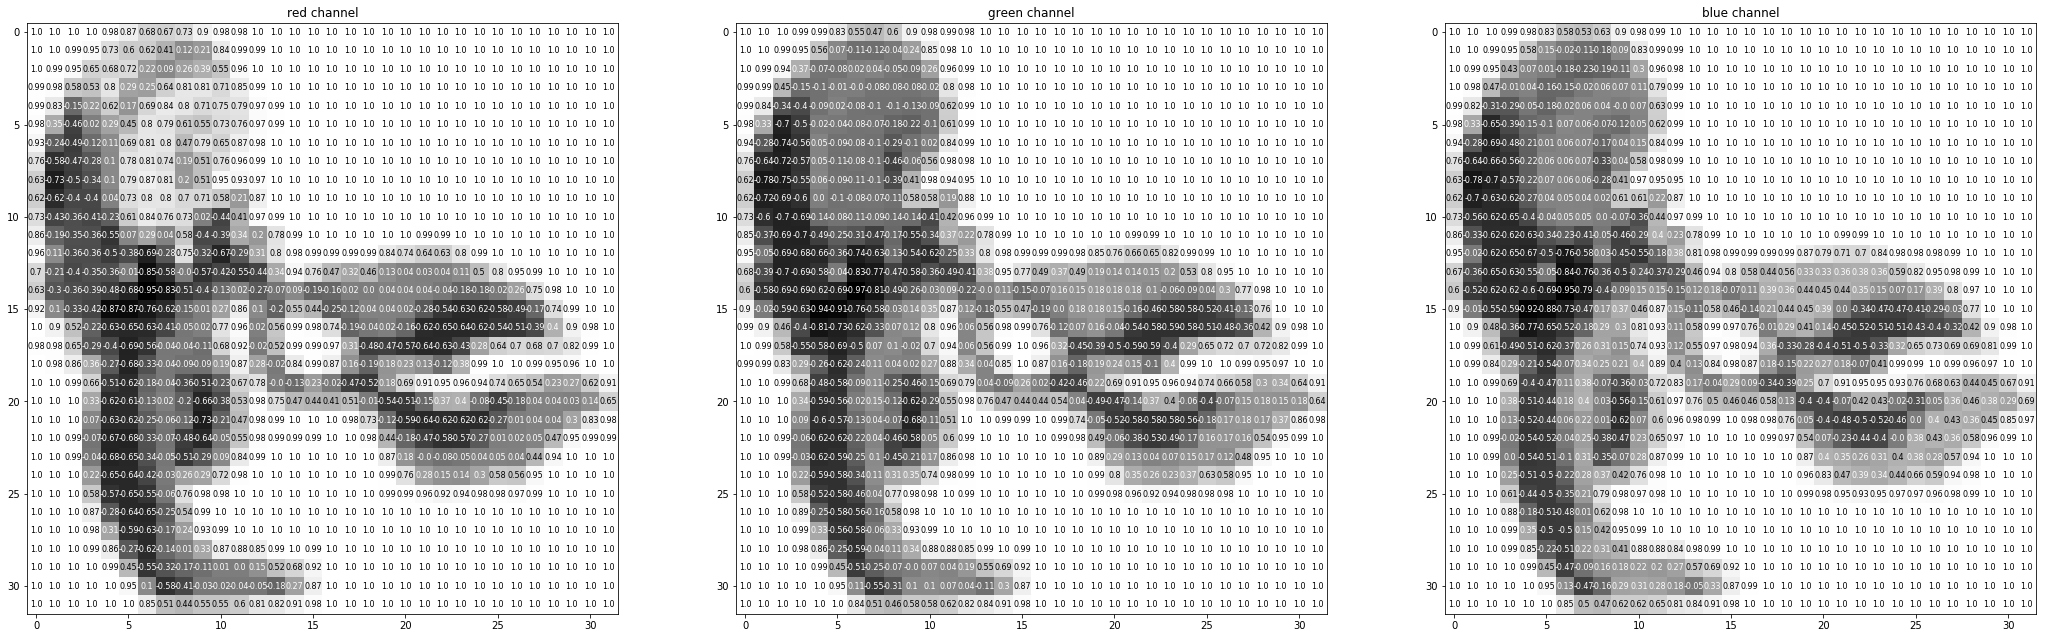

In [0]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [189]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


In [0]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [191]:
# number of epochs to train the model
n_epochs = 50

loss_min = np.Inf

for epoch in range(1, n_epochs+1):

    # keep track of training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in trainloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.sampler)
    
    # save model when train loss is minimized
    if train_loss <= loss_min:
      torch.save(model.state_dict(), 'model_pokemon.pt')
      loss_min = train_loss
        
    # print training statistics 
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, train_loss))

    

Epoch: 1 	Training Loss: 2.304065
Epoch: 2 	Training Loss: 2.301763
Epoch: 3 	Training Loss: 2.296764
Epoch: 4 	Training Loss: 2.296440
Epoch: 5 	Training Loss: 2.290913
Epoch: 6 	Training Loss: 2.288374
Epoch: 7 	Training Loss: 2.283510
Epoch: 8 	Training Loss: 2.277877
Epoch: 9 	Training Loss: 2.273269
Epoch: 10 	Training Loss: 2.258860
Epoch: 11 	Training Loss: 2.241220
Epoch: 12 	Training Loss: 2.226866
Epoch: 13 	Training Loss: 2.209748
Epoch: 14 	Training Loss: 2.185689
Epoch: 15 	Training Loss: 2.153512
Epoch: 16 	Training Loss: 2.118042
Epoch: 17 	Training Loss: 2.102366
Epoch: 18 	Training Loss: 2.130402
Epoch: 19 	Training Loss: 2.045283
Epoch: 20 	Training Loss: 2.174218
Epoch: 21 	Training Loss: 1.981802
Epoch: 22 	Training Loss: 2.056034
Epoch: 23 	Training Loss: 1.956280
Epoch: 24 	Training Loss: 2.029462
Epoch: 25 	Training Loss: 1.867358
Epoch: 26 	Training Loss: 1.842289
Epoch: 27 	Training Loss: 1.735221
Epoch: 28 	Training Loss: 1.813619
Epoch: 29 	Training Loss: 2.2

In [192]:
model.load_state_dict(torch.load('model_pokemon.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [233]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.372153

Test Accuracy of Abomasnow: 100% ( 3/ 3)
Test Accuracy of  Abra: 100% ( 1/ 1)
Test Accuracy of Absol: N/A (no training examples)
Test Accuracy of Accelgor: N/A (no training examples)
Test Accuracy of Aegislash: 33% ( 1/ 3)
Test Accuracy of Aerodactyl: 100% ( 1/ 1)
Test Accuracy of Aggron: 33% ( 2/ 6)
Test Accuracy of Aipom: 50% ( 1/ 2)
Test Accuracy of Alakazam:  0% ( 0/ 2)
Test Accuracy of Alomomola:  0% ( 0/ 2)

Test Accuracy (Overall): 45% ( 9/20)


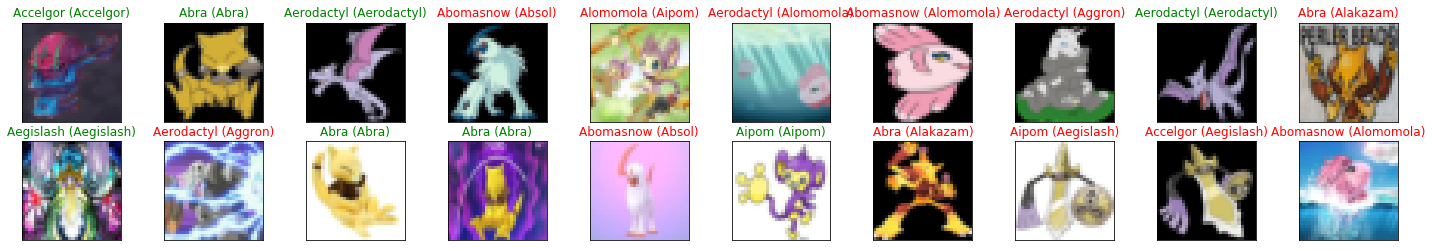

In [250]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))